In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from numpy.lib.recfunctions import repack_fields
from numpy.lib.stride_tricks import as_strided

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, BatchNormalization, Dropout, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

np.set_printoptions(threshold=np.inf)
plt.style.use('ggplot')

## Read Dataset

In [2]:
usecols = np.array(['HUMI', 'PRES', 'Iws', 'Iprec', 'PM_US_Post'])
n_feature = usecols[:-1].shape[0]
labels = np.array([0, 1, 2])
n_classes = labels.shape[0]

recs = []

for i in os.listdir('dataset/'):
    fname = 'dataset/{}'.format(i)
    recs.append(np.genfromtxt(fname,
                    delimiter=',',
                    names=True,
                    dtype=np.float64,
                    usecols=usecols,
                    )
            )
    
recs.__len__()

5

## Covent Label

In [3]:
for rec in recs:
    rec['PM_US_Post'][rec['PM_US_Post'] < 10] = labels[0]
    rec['PM_US_Post'][(rec['PM_US_Post'] <= 25) & (rec['PM_US_Post'] >= 10)] = labels[1]
    rec['PM_US_Post'][rec['PM_US_Post'] > 25] = labels[2]

recs.__len__()

5

## Drop Duplicate

In [4]:
for i in range(recs.__len__()):
    recs[i] = np.unique(recs[i], axis=0)

recs.__len__()

5

## Drop Label NaN

In [5]:
for i in range(len(recs)):
    recs[i] = recs[i][~np.isnan(recs[i]['PM_US_Post'])]

recs.__len__()

5

## Visualization

In [6]:
rec_view = np.concatenate(recs)

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


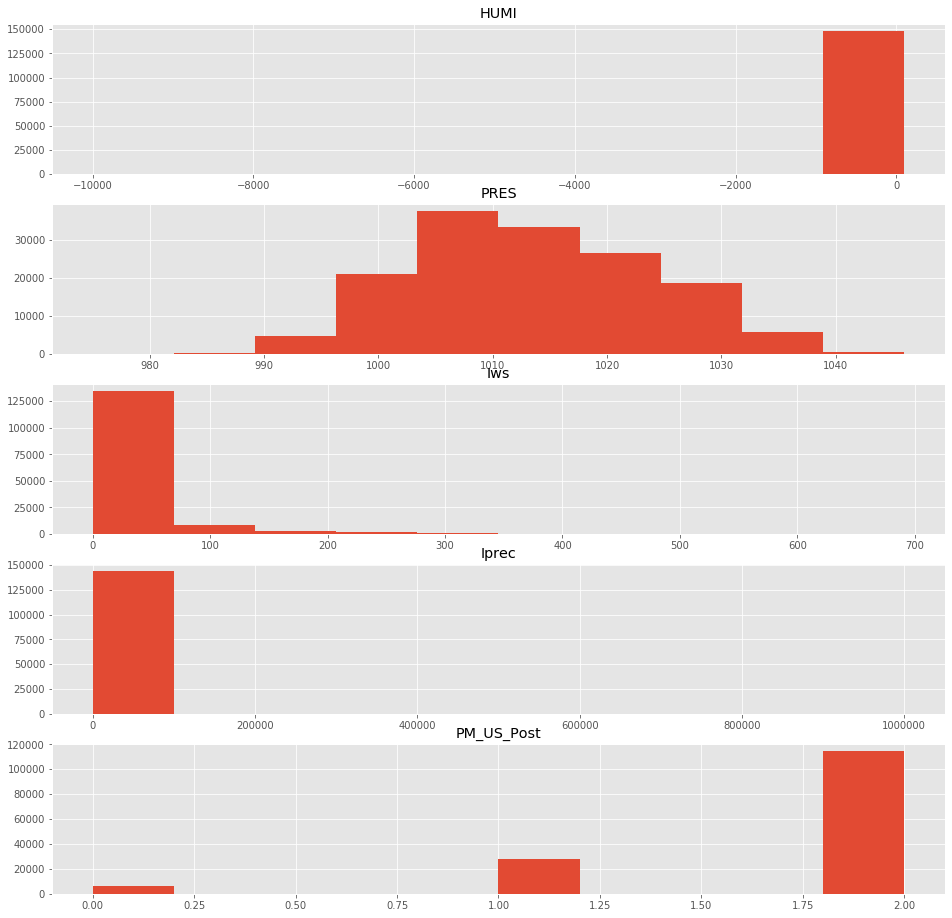

In [7]:
fig, ax = plt.subplots(rec_view.dtype.__len__(), 1, figsize = (16, 16))
for i, col in enumerate(rec_view.dtype.names):
    ax[i].hist(rec_view[col])
    ax[i].set_title(col)

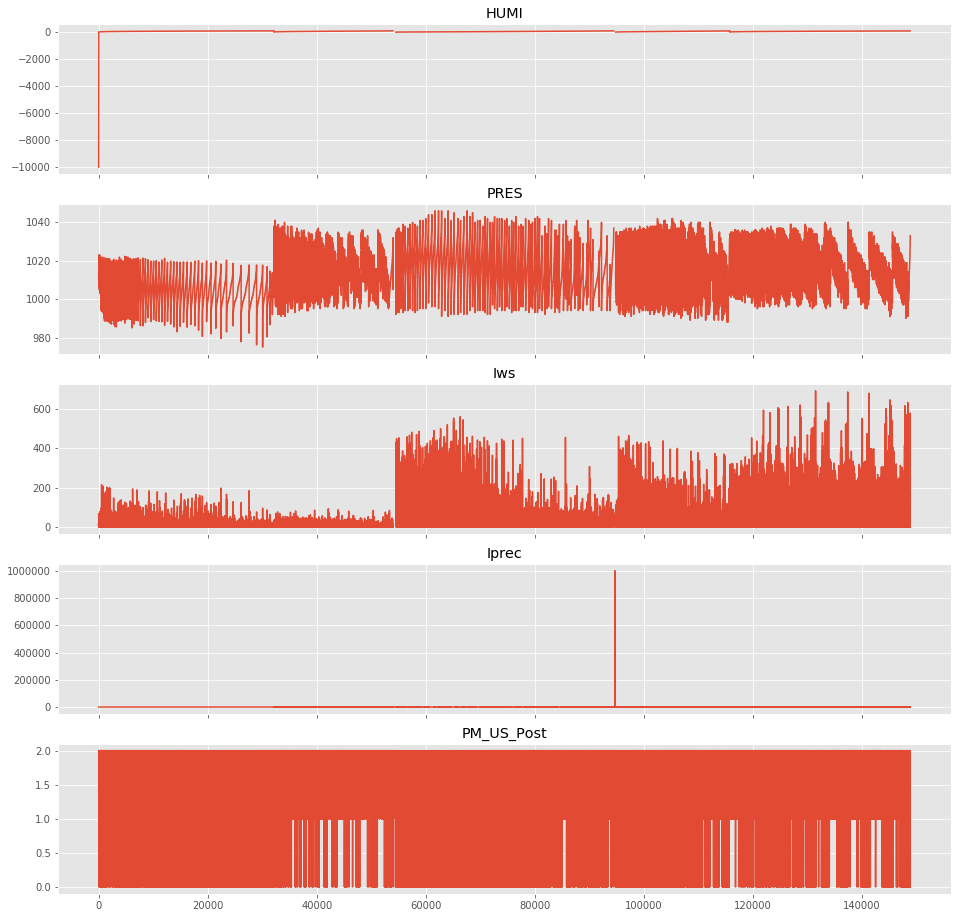

In [8]:
fig, ax = plt.subplots(rec_view.dtype.__len__(), 1, figsize = (16, 16), sharex=True)
for i, col in enumerate(rec_view.dtype.names):
    ax[i].plot(rec_view[col])
    ax[i].set_title(col)

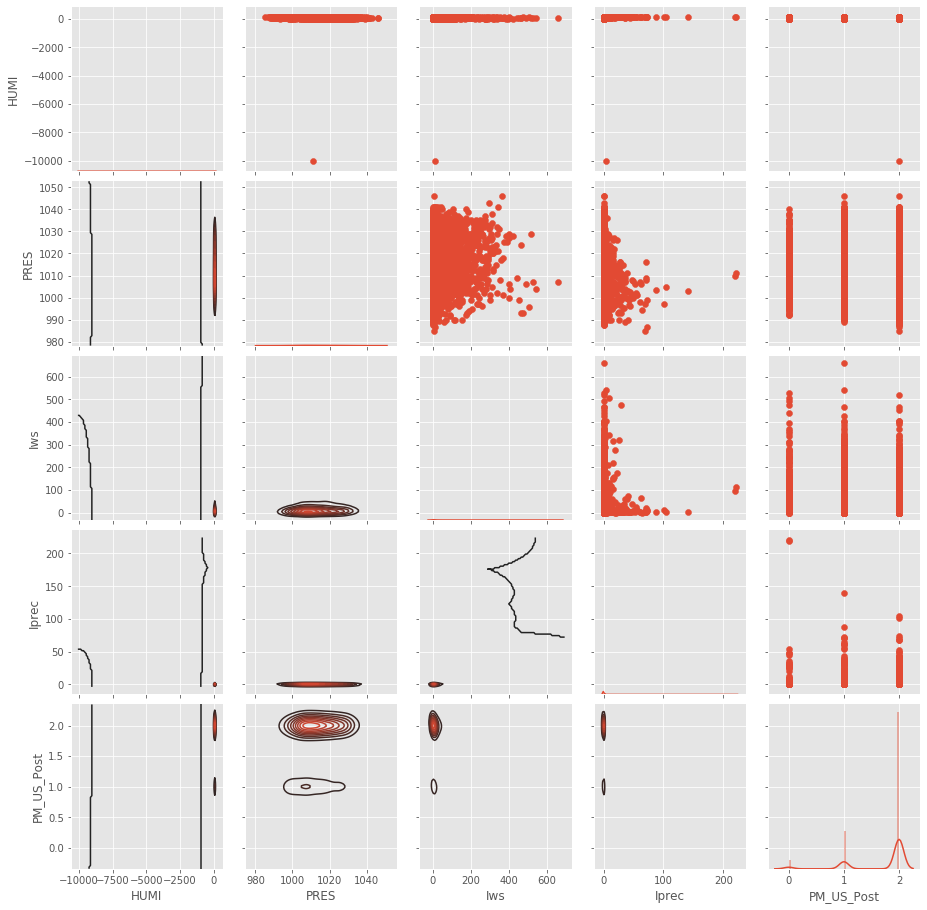

In [9]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(rec_view[::16])
g = sns.PairGrid(df)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)
g.map_diag(sns.distplot)

## Show NaN row

In [10]:
for rec in recs:
    view = rec.view(np.float64).reshape(-1, rec.dtype.__len__())
    print(rec[np.any(np.isnan(view), axis=1)][:8])

[(nan, nan, nan, nan, 2.)]
[(24.18, 1020.,  5., nan, 2.) (26.17, 1017., nan,  0., 1.)
 (28.14, 1016., nan,  0., 1.) (28.43, 1013., nan,  0., 1.)
 (29.57, 1008., nan,  0., 1.) (30.23, 1015., nan,  0., 1.)
 (30.65, 1003.,  2., nan, 2.) (30.71, 1007.,  2., nan, 1.)]
[( 6., 1013.,   7.15, nan, 2.) ( 7., 1014.,  16.09, nan, 1.)
 ( 8., 1009.,  92.53, nan, 2.) ( 8., 1016.,  30.39, nan, 1.)
 ( 9., 1010., 105.49, nan, 2.) ( 9., 1015.,  23.24, nan, 1.)
 ( 9., 1020.,   4.92, nan, 1.) (10., 1018.,   3.13, nan, 1.)]
[( 9.83, 1015., 32., nan, 2.) (10.01, 1014., 35., nan, 2.)
 (10.8 , 1022.,  1., nan, 2.) (10.84, 1013., 41., nan, 2.)
 (11.32, 1015., 27., nan, 2.) (12.05, 1017., 33., nan, 2.)
 (12.05, 1018.,  8., nan, 1.) (12.1 , 1026.,  5., nan, 2.)]
[(21.54, 1023., 61., nan, 2.) (22.86, 1014., 27., nan, 2.)
 (25.82, 1020., 15., nan, 2.) (26.55, 1009., 18., nan, 2.)
 (27.29, 1023., 54., nan, 2.) (27.31, 1021.,  2., nan, 2.)
 (28.43, 1017.,  3., nan, 1.) (28.43, 1017.,  6., nan, 1.)]


## Interpolation

In [11]:
for rec in recs:
    for i, col in enumerate(rec.dtype.names[:-1]):
        indices = np.arange(rec[col].shape[0])
        not_nan = ~np.isnan(rec[col])
        rec[col] = np.interp(indices, indices[not_nan], rec[col][not_nan])

## Fill Outlier with 3SD

In [12]:
for rec in recs:
    for i, col in enumerate(rec.dtype.names[:-1]):
        upper_bound = 3*np.std(rec[col])
        cond = abs(rec[col] - np.mean(rec[col])) > upper_bound
        rec[col][cond] = upper_bound

## Moving Average

In [13]:
for rec in recs:
    for i, col in enumerate(rec.dtype.names[:-1]):
        rec[col] = np.convolve(rec[col], np.ones(2)/2, mode='same')

## Standardization Normalization

In [14]:
for rec in recs:
    for i, col in enumerate(rec.dtype.names[:-1]):
        rec[col] = (rec[col] - rec[col].mean()) / rec[col].std()

## Visualization

In [15]:
rec_view = np.concatenate(recs)

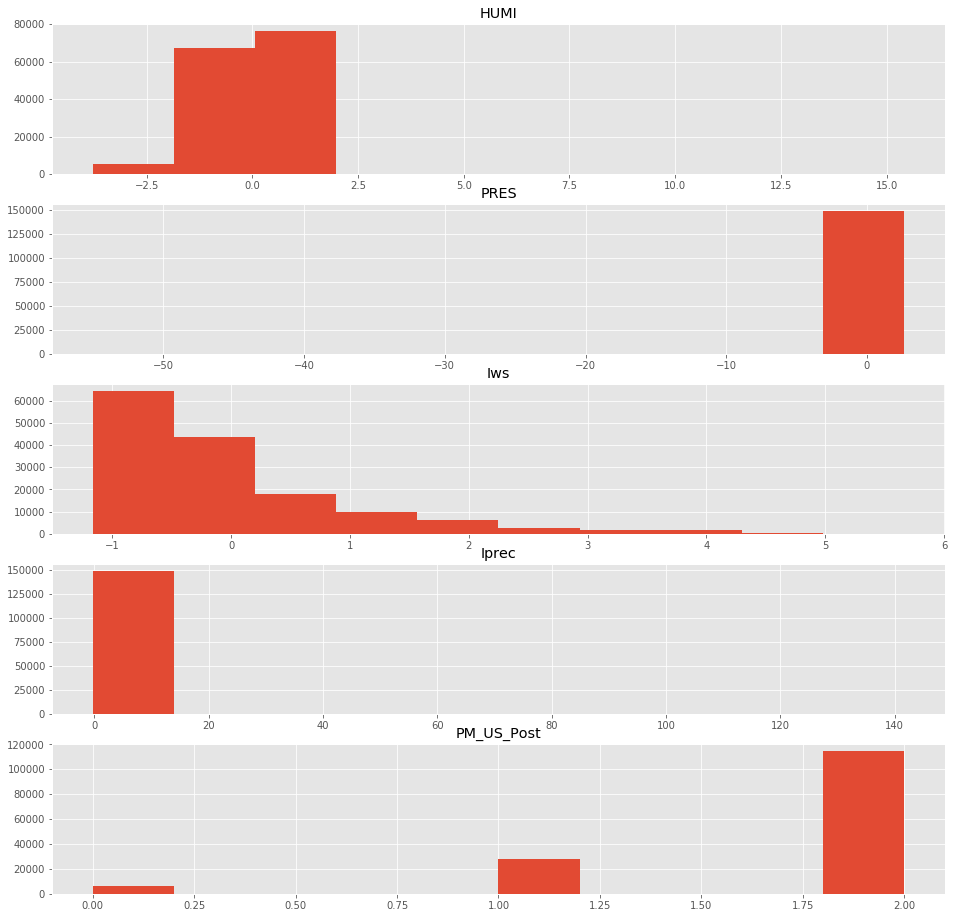

In [16]:
fig, ax = plt.subplots(rec_view.dtype.__len__(), 1, figsize = (16, 16))
for i, col in enumerate(rec_view.dtype.names):
    ax[i].hist(rec_view[col])
    ax[i].set_title(col)

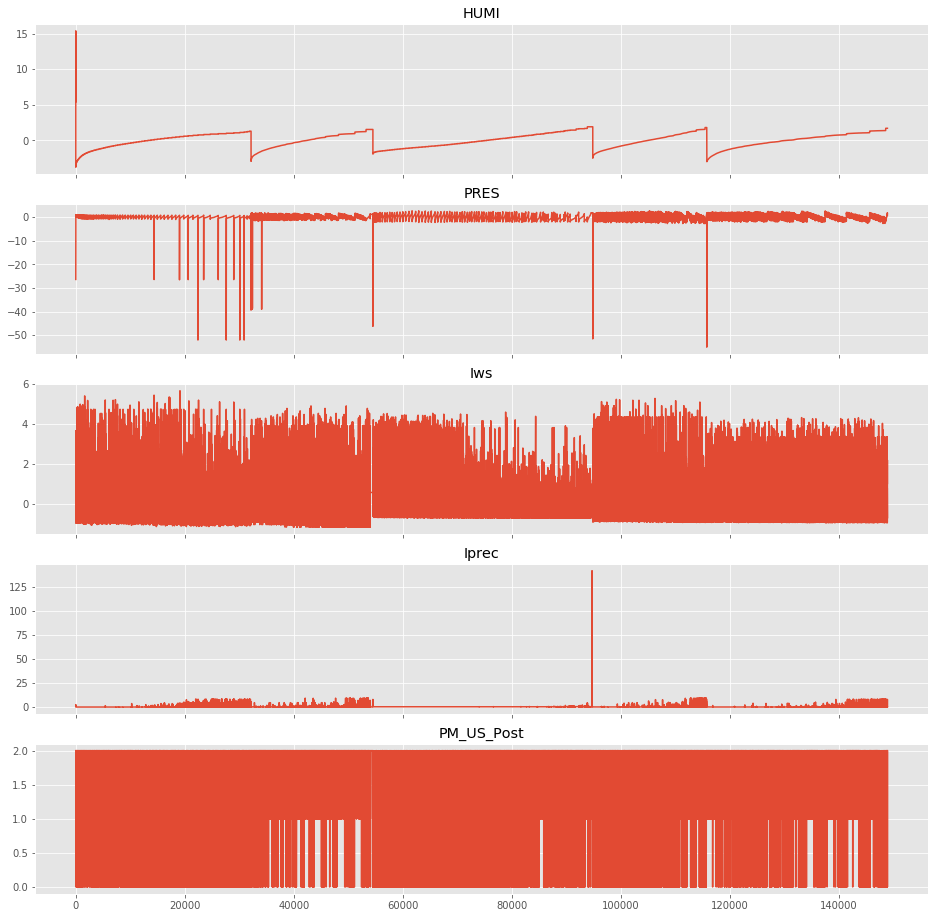

In [17]:
fig, ax = plt.subplots(rec_view.dtype.__len__(), 1, figsize = (16, 16), sharex=True)
for i, col in enumerate(rec_view.dtype.names):
    ax[i].plot(rec_view[col])
    ax[i].set_title(col)

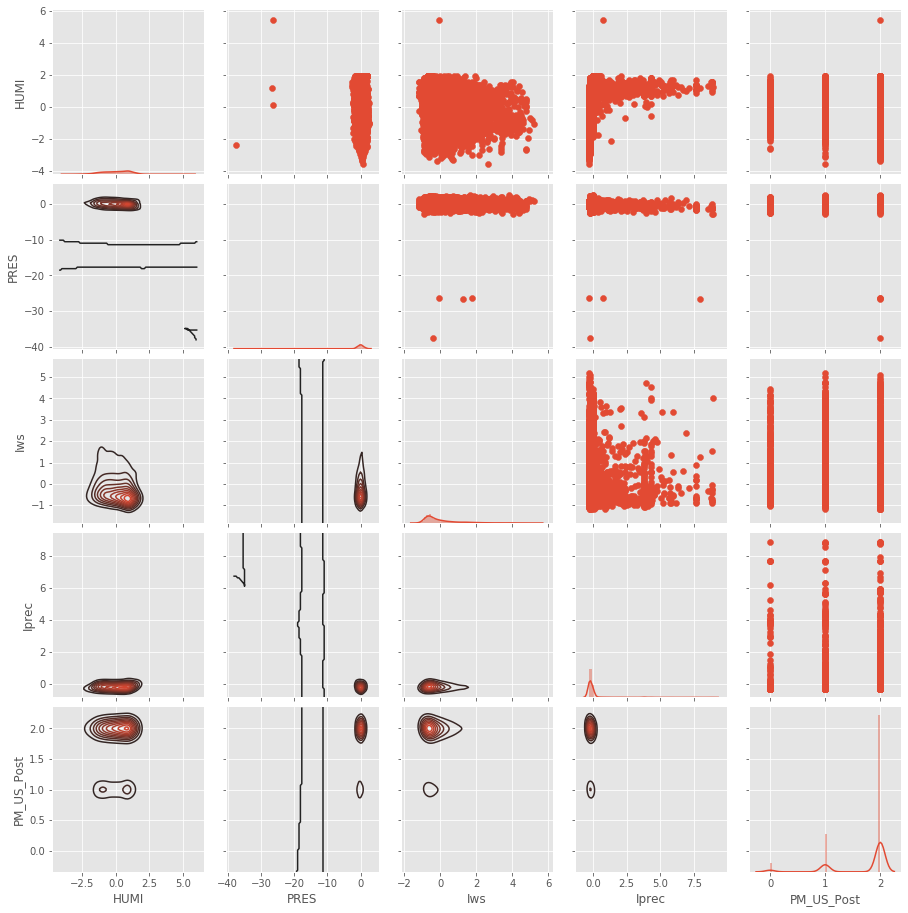

In [18]:
df = pd.DataFrame(rec_view[::16])
g = sns.PairGrid(df)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)
g.map_diag(sns.distplot)

## Count Label

In [19]:
for rec in recs:
    unique, counts = np.unique(rec['PM_US_Post'], return_counts=True)
    print(dict(zip(unique, counts)), counts/counts.max())

{0.0: 1581, 1.0: 7076, 2.0: 23488} [0.06731097 0.30126022 1.        ]
{0.0: 220, 1.0: 1683, 2.0: 20446} [0.01076005 0.08231439 1.        ]
{0.0: 2395, 1.0: 9025, 2.0: 28906} [0.08285477 0.31221892 1.        ]
{0.0: 758, 1.0: 3113, 2.0: 17035} [0.04449662 0.18274141 1.        ]
{0.0: 1585, 1.0: 6699, 2.0: 24851} [0.06378013 0.26956662 1.        ]



## Covent Time-series format

In [20]:
def create_strided(arr, step, windows):
    itemsize = np.dtype(np.float64).itemsize
    shape = ((arr.shape[0] -windows)//step +1, windows, n_feature, 1)
    strides = (step*(n_feature)*itemsize, n_feature*itemsize, itemsize, itemsize)

    arr_windows = as_strided(arr, shape=shape, strides=strides)
    return arr_windows

## Create Time-series with Over sampling imbalance

In [21]:
step = 16
windows = 64

rec_windows = []
rec_labels = []

for rec in recs:
    unique, counts = np.unique(rec['PM_US_Post'], return_counts=True)
    repeat = 1//(counts/counts.max())
    for label, times in zip(labels, repeat):
        arr = repack_fields(rec[usecols[:-1]][rec['PM_US_Post'] == label]).view(np.float64).reshape(-1, n_feature)
        arr = np.repeat(arr, times, axis=0)
        j = create_strided(arr, step, windows)
        rec_windows.append(j)
        rec_labels.append(np.repeat(label, j.shape[0]))

rec_windows = np.concatenate(rec_windows)
rec_labels = np.concatenate(rec_labels)

rec.shape, rec_windows.shape, rec_labels.shape

((33135,), (20602, 64, 4, 1), (20602,))

## One-Hot Encoder

In [22]:
one_hot = np.zeros((rec_labels.shape[0], 1, labels.shape[0]))
for i, unique_value in enumerate(labels):
    one_hot[:, :, i][rec_labels == unique_value] = 1

rec_labels_onehot = one_hot.reshape(-1, labels.shape[0]*1)

rec_labels_onehot.shape

(20602, 3)

## Train & Test Split

In [23]:
random_state = 0

# np.random.seed(random_state)
# np.random.shuffle(rec_windows)

# np.random.seed(random_state)
# np.random.shuffle(rec_labels_onehot)

# rec_windows.shape, rec_labels_onehot.shape

In [24]:
train_size = 0.8
# Implement stratified samples
# sample = int(train_size*rec_labels_onehot.shape[0])

# X_train, X_test = rec_windows[:sample], rec_windows[sample:]
# y_train, y_test = rec_labels_onehot[:sample], rec_labels_onehot[sample:]

# X_train.shape, X_test.shape

In [25]:
X_4d_train, X_4d_test, y_train, y_test = train_test_split(rec_windows, rec_labels_onehot, train_size=train_size, random_state=random_state, stratify=rec_labels_onehot)

X_3d_train = X_4d_train.reshape(-1, windows, n_feature)
X_3d_test = X_4d_test.reshape(-1, windows, n_feature)

y_train_single = y_train.argmax(axis=1)
y_test_single = y_test.argmax(axis=1)

X_4d_train.shape, X_4d_test.shape, y_train.shape, y_test.shape

((16481, 64, 4, 1), (4121, 64, 4, 1), (16481, 3), (4121, 3))

In [26]:
unique, counts_train = np.unique(y_train.argmax(axis=1), return_counts=True)
unique, counts_test = np.unique(y_test.argmax(axis=1), return_counts=True)

counts_train, counts_test

(array([5565, 5194, 5722]), array([1391, 1299, 1431]))

## CNN Model

In [27]:
def create_cnn(input_shape=X_4d_train.shape[1:], num_classes=y_train.shape[1],
               conv=(128, 128, 64), conv_drop=(0.2,),
               kernel_size=(3, 3), pool_size=(2, 2), strides=(2, 2),
               dense=(128, 128), dense_dropout=(0.2, 0.2),
               activation='relu',
               optimizer='adam',
               lr=0.001, beta_1=0.9, beta_2=0.999):
    model = Sequential()

    model.add(Conv2D(conv[0], kernel_size=kernel_size, activation=activation, padding='same', input_shape=input_shape))
    model.add(Conv2D(conv[1], kernel_size=kernel_size, activation=activation, padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=pool_size, strides=strides))
    model.add(Dropout(conv_drop[0]))
    
    model.add(Conv2D(conv[2], kernel_size=kernel_size, activation=activation, padding='same'))
    model.add(BatchNormalization())

    model.add(Flatten())

    model.add(Dense(dense[0], activation=activation))
    model.add(Dropout(dense_dropout[0]))

    model.add(Dense(dense[1], activation=activation))
    model.add(Dropout(dense_dropout[1]))

    model.add(Dense(num_classes, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2, amsgrad=False)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

cnn = create_cnn()
cnn.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 4, 128)        1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 4, 128)        147584    
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 4, 128)        512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 2, 128)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 2, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 2, 64)         73792     
____

In [28]:
def create_lstm(input_shape=X_3d_train.shape[1:], num_classes=y_train.shape[1],
                dense=(128,), dense_dropout=(0.2,),
                activation='relu',
                optimizer='adam',
                lr=0.001, beta_1=0.9, beta_2=0.999):
    model = Sequential()

    model.add(LSTM(dense[0], activation=activation, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(dense_dropout[0]))

    model.add(Dense(num_classes, activation='sigmoid'))

#     optimizer = Adam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2, amsgrad=False)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

lstm = create_lstm()
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               68096     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 68,995
Trainable params: 68,739
Non-trainable params: 256
_________________________________________________________________


## Train

In [29]:
cnn_batch_size = 128
cnn_epochs = 8

cnn = create_cnn()
cnn_history = cnn.fit(X_4d_train, y_train, batch_size=cnn_batch_size, epochs=cnn_epochs, validation_data=(X_4d_test, y_test))

Train on 16481 samples, validate on 4121 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/8
16481/16481 [==============================] - 3s 185us/sample - loss: 0.4149 - acc: 0.8303 - val_loss: 1.9765 - val_acc: 0.4763
Epoch 2/8
16481/16481 [==============================] - 2s 104us/sample - loss: 0.1892 - acc: 0.9239 - val_loss: 2.4786 - val_acc: 0.3822
Epoch 3/8
16481/16481 [==============================] - 1s 78us/sample - loss: 0.0968 - acc: 0.9625 - val_loss: 1.3909 - val_acc: 0.6433
Epoch 4/8
16481/16481 [==============================] - 1s 77us/sample - loss: 0.0416 - acc: 0.9853 - val_loss: 0.0838 - val_acc: 0.9636
Epoch 5/8
16481/16481 [==============================] - 1s 77us/sample - loss: 0.0264 - acc: 0.9906 - val_loss: 0.0549 - val_acc: 0.9816
Epoch 6/8
16481/16481 [==============================] - 1s 77us/sample - loss: 0.0242 - acc: 0.9914 - val_loss: 0.0140 - val_acc: 0.9949
Epoch 7/8
16481/16481 [====

In [30]:
lstm_batch_size = 64
lstm_epochs = 8

lstm = create_lstm()
lstm_history = lstm.fit(X_3d_train, y_train, batch_size=lstm_batch_size, epochs=lstm_epochs, validation_data=(X_3d_test, y_test))

Train on 16481 samples, validate on 4121 samples
Epoch 1/8
16481/16481 [==============================] - 23s 1ms/sample - loss: 1.0044 - acc: 0.4985 - val_loss: 1.0849 - val_acc: 0.4676
Epoch 2/8
16481/16481 [==============================] - 22s 1ms/sample - loss: 0.9548 - acc: 0.5304 - val_loss: 1.0218 - val_acc: 0.5232
Epoch 3/8
16481/16481 [==============================] - 22s 1ms/sample - loss: 0.8758 - acc: 0.5854 - val_loss: 0.9352 - val_acc: 0.5758
Epoch 4/8
16481/16481 [==============================] - 22s 1ms/sample - loss: 0.7896 - acc: 0.6336 - val_loss: 0.8473 - val_acc: 0.6042
Epoch 5/8
16481/16481 [==============================] - 22s 1ms/sample - loss: 0.7025 - acc: 0.6805 - val_loss: 0.8019 - val_acc: 0.6200
Epoch 6/8
16481/16481 [==============================] - 22s 1ms/sample - loss: 0.6178 - acc: 0.7226 - val_loss: 0.6520 - val_acc: 0.6904
Epoch 7/8
16481/16481 [==============================] - 22s 1ms/sample - loss: 0.5651 - acc: 0.7486 - val_loss: 0.5402 - v

## Training accuracy and Training Loss Graph

### CNN

Text(0, 0.5, 'Training loss')

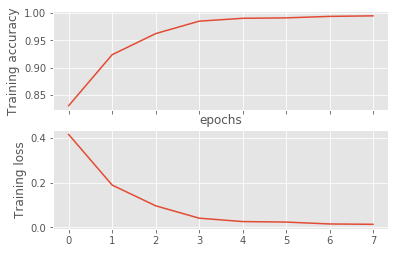

In [31]:
fig, ax = plt.subplots(2, sharex=True)

ax[0].plot(cnn_history.history['acc'], label=cnn)
ax[1].plot(cnn_history.history['loss'], label=cnn)
 
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Training accuracy')
ax[1].set_ylabel('Training loss')

Text(0, 0.5, 'Training loss')

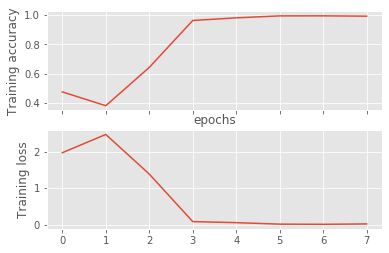

In [32]:
fig, ax = plt.subplots(2, sharex=True)

ax[0].plot(cnn_history.history['val_acc'], label=cnn)
ax[1].plot(cnn_history.history['val_loss'], label=cnn)
 
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Training accuracy')
ax[1].set_ylabel('Training loss')

### LSTM

Text(0, 0.5, 'Training loss')

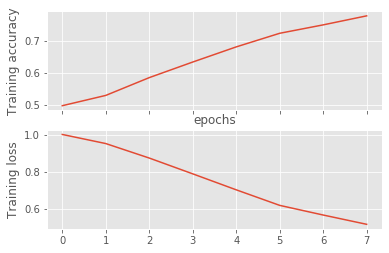

In [33]:
fig, ax = plt.subplots(2, sharex=True)

ax[0].plot(lstm_history.history['acc'], label=lstm)
ax[1].plot(lstm_history.history['loss'], label=lstm)
 
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Training accuracy')
ax[1].set_ylabel('Training loss')

Text(0, 0.5, 'Training loss')

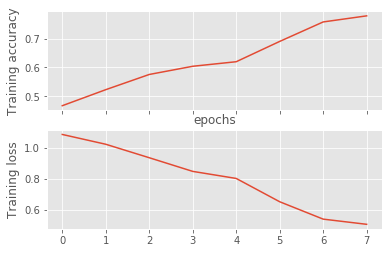

In [34]:
fig, ax = plt.subplots(2, sharex=True)

ax[0].plot(lstm_history.history['val_acc'], label=lstm)
ax[1].plot(lstm_history.history['val_loss'], label=lstm)
 
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Training accuracy')
ax[1].set_ylabel('Training loss')

## Evaluate

In [35]:
cnn_score = cnn.evaluate(X_4d_test, y_test)
lstm_score = lstm.evaluate(X_3d_test, y_test)

cnn_score, lstm_score

4121/4121 [==============================] - 4s 1ms/sample - loss: 0.5069 - acc: 0.7789


([0.019942159286001626, 0.9929629], [0.5068611011462315, 0.77893716])

## Classification Report

In [36]:
cnn_pred = cnn.predict_classes(X_4d_test)
lstm_pred = lstm.predict_classes(X_3d_test)

print('CNN')
print(classification_report(y_test_single, cnn_pred))
print('LSTM')
print(classification_report(y_test_single, lstm_pred))

CNN
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1391
           1       1.00      0.99      0.99      1299
           2       0.99      1.00      0.99      1431

    accuracy                           0.99      4121
   macro avg       0.99      0.99      0.99      4121
weighted avg       0.99      0.99      0.99      4121

LSTM
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1391
           1       0.65      0.68      0.67      1299
           2       0.85      0.88      0.86      1431

    accuracy                           0.78      4121
   macro avg       0.78      0.78      0.78      4121
weighted avg       0.78      0.78      0.78      4121



## Confusion Matrix

In [37]:
print('CNN')
print(np.bincount(y_test_single*n_classes +cnn_pred).reshape((n_classes, n_classes)))
print('LSTM')
print(np.bincount(y_test_single*n_classes +lstm_pred).reshape((n_classes, n_classes)))

CNN
[[1379    2   10]
 [   6 1283   10]
 [   1    0 1430]]
LSTM
[[1075  296   20]
 [ 222  882  195]
 [   3  175 1253]]


# GridSearch

## Cross Validation

In [58]:
n_splits = 2

skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

In [59]:
param_grid_cnn = {
#     'conv': [(64, 64, 32), (128, 128, 64)],
#     'activation': ['relu', 'tanh'],
    'optimizer': ['adam', 'adadelta'],
#     'batch_size': [cnn_batch_size],
#     'epochs': [cnn_epochs],
}

param_grid_lstm = {
#     'dense': [(64, 64), (128, 128)],
#     'activation': ['relu', 'tanh'],
    'optimizer': ['adam', 'adadelta'],
#     'batch_size': [lstm_batch_size],
#     'epochs': [lstm_epochs]
}

In [61]:
cnn_keras = KerasClassifier(build_fn=create_cnn,  epochs=cnn_epochs, batch_size=cnn_batch_size, verbose=0)
lstm_keras = KerasClassifier(build_fn=create_lstm,  epochs=lstm_epochs, batch_size=lstm_batch_size, verbose=0)

gsCV_cnn = GridSearchCV(estimator=cnn_keras, param_grid=param_grid_cnn, scoring='accuracy', n_jobs=1, cv=skfold)
gsCV_lstm = GridSearchCV(estimator=lstm_keras, param_grid=param_grid_cnn, scoring='accuracy', n_jobs=1, cv=skfold)

## Train

In [62]:
gsCV_cnn.fit(X_4d_train, y_train_single, validation_data=(X_4d_test, y_test))

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=0, shuffle=True),
             error_score='raise-deprecating',
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7ff3a80bfe80>,
             iid='warn', n_jobs=1,
             param_grid={'optimizer': ['adam', 'adadelta']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [63]:
gsCV_lstm.fit(X_3d_train, y_train_single, validation_data=(X_3d_test, y_test))

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=0, shuffle=True),
             error_score='raise-deprecating',
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7ff3d38d3748>,
             iid='warn', n_jobs=1,
             param_grid={'optimizer': ['adam', 'adadelta']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

## Best Score CNN

In [64]:
print('best score: ', gsCV_cnn.best_score_, gsCV_cnn.best_params_)

means_cnn = gsCV_cnn.cv_results_['mean_test_score']
stds_cnn = gsCV_cnn.cv_results_['std_test_score']
params_cnn = gsCV_cnn.cv_results_['params']
for mean, stdev, param in zip(means_cnn, stds_cnn, params_cnn):
    print(f'{mean} ({stdev}) with: {param}')

best score:  0.8691826952248043 {'optimizer': 'adadelta'}
0.6398276803592015 (0.3021879850426193) with: {'optimizer': 'adam'}
0.8691826952248043 (0.0129767115520243) with: {'optimizer': 'adadelta'}


## Best Score LSTM

In [65]:
print('best score: ', gsCV_lstm.best_score_, gsCV_lstm.best_params_)

means_lstm = gsCV_lstm.cv_results_['mean_test_score']
stds_lstm = gsCV_lstm.cv_results_['std_test_score']
params_lstm = gsCV_lstm.cv_results_['params']
for mean, stdev, param in zip(means_lstm, stds_lstm, params_lstm):
    print(f'{mean} ({stdev}) with: {param}')

best score:  0.574054972392452 {'optimizer': 'adam'}
0.574054972392452 (0.1105256997952501) with: {'optimizer': 'adam'}
0.33268612341484133 (0.02455356559805172) with: {'optimizer': 'adadelta'}


## Classification Report

In [67]:
cnn_pred = gsCV_cnn.predict(X_4d_test)
lstm_pred = gsCV_lstm.predict(X_3d_test)

print('CNN')
print(classification_report(y_test_single, cnn_pred))
print('LSTM')
print(classification_report(y_test_single, lstm_pred))

CNN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1391
           1       0.99      1.00      0.99      1299
           2       1.00      1.00      1.00      1431

    accuracy                           1.00      4121
   macro avg       1.00      1.00      1.00      4121
weighted avg       1.00      1.00      1.00      4121

LSTM
              precision    recall  f1-score   support

           0       0.68      0.43      0.53      1391
           1       0.36      0.76      0.49      1299
           2       0.71      0.26      0.38      1431

    accuracy                           0.47      4121
   macro avg       0.58      0.48      0.47      4121
weighted avg       0.59      0.47      0.46      4121



## Confusion Matrix

In [68]:
print('CNN')
print(np.bincount(y_test_single*n_classes +cnn_pred).reshape((n_classes, n_classes)))
print('LSTM')
print(np.bincount(y_test_single*n_classes +lstm_pred).reshape((n_classes, n_classes)))

CNN
[[1385    6    0]
 [   2 1296    1]
 [   0    5 1426]]
LSTM
[[602 744  45]
 [209 987 103]
 [ 75 991 365]]
